In [2]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2026-01-28 21:56:59.277308: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-28 21:56:59.374264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-28 21:56:59.374301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-28 21:56:59.386466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-28 21:56:59.415954: I tensorflow/core/platform/cpu_feature_guar

In [3]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
param_names_key_rp = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1']
param_names_bias = ['b2', 'bs2', 'bl']
param_names_bias_rp = ['sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']
param_names_noise_rp = ['An_homog', 'sigma8_cold_x_An_b1', 'sigma8_cold_sq_x_An_b2', 'sigma8_cold_sq_x_An_bs2', 'sigma8_cold_x_An_bl']

In [6]:
def setup_inference_tags(data_mode, tag_params, tag_biasparams, statistics_arr, tag_noise=None, tag_Anoise=None, 
                         tag_reparam='_rp', n_train=10000, tags_mask=None):
    tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
    
    # Handle tags_mask - default to empty strings if not provided
    if tags_mask is None:
        tags_mask = [''] * len(tag_stats_arr)
    
    if tag_noise is None:
        tags_inf = [f'_{data_mode}{tag_stats_arr[i]}{tags_mask[i]}{tag_params}{tag_biasparams}{tag_reparam}_ntrain{n_train}' 
                   for i in range(len(tag_stats_arr))]
    else:
        tags_inf = [f'_{data_mode}{tag_stats_arr[i]}{tags_mask[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}{tag_reparam}_ntrain{n_train}' 
                   for i in range(len(tag_stats_arr))]
    
    labels = [utils.get_stat_label(stat) for stat in statistics_arr]
    colors = utils.get_stat_colors(statistics_arr)
    
    return tags_inf, labels, colors, tag_stats_arr


def load_training_params(tag_params, tag_biasparams, tag_Anoise=None):
    """
    Load training set parameters and determine which parameters vary.
    
    Returns:
    --------
    cosmo_param_names_vary : list
        List of cosmological parameter names that vary
    bias_param_names_vary : list
        List of bias parameter names that vary
    noise_param_names_vary : list
        List of noise parameter names that vary
    param_names_vary : list
        Combined list of all varying parameter names
    """
    params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)
    
    cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
    if params_df is not None:
        cosmo_param_names_vary = params_df.columns.tolist()
    if biasparams_df is not None:
        bias_param_names_vary = biasparams_df.columns.tolist()
    if Anoise_df is not None:
        noise_param_names_vary = Anoise_df.columns.tolist()
    
    param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
    return cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary, param_names_vary


def load_test_predictions(tags_inf, tags_data_test, tag_params_test, tags_biasparams_test,
                          cosmo_param_names_vary, bias_param_names_vary, param_names_vary,
                          tag_reparam='_rp', n_test_eval=None, param_names_show=None,
                          tags_Anoise_test=None, noise_param_names_vary=None):
    if param_names_show is None:
        # Get param_names from first inference to determine what to show
        _, _, param_names = utils.get_moments_test_sbi(tags_inf[0], tag_test=tags_data_test[0])
        param_names_show = param_names.tolist()
    
    # Handle tags_Anoise_test - convert to list if string
    if tags_Anoise_test is not None:
        if isinstance(tags_Anoise_test, str):
            tags_Anoise_test_list = [tags_Anoise_test] * len(tags_inf)
        else:
            tags_Anoise_test_list = tags_Anoise_test
    else:
        tags_Anoise_test_list = [None] * len(tags_inf)
    
    theta_true_arr, theta_pred_arr, vars_pred_arr, covs_pred_arr = [], [], [], []
    
    for i, tag_inf in enumerate(tags_inf):
        _theta_test_pred, _covs_test_pred, param_names = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i])
        
        theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i],
                                                 tag_Anoise_test=tags_Anoise_test_list[i],
                                                 cosmo_param_names_vary=cosmo_param_names_vary,
                                                 bias_param_names_vary=bias_param_names_vary,
                                                 noise_param_names_vary=noise_param_names_vary)
        
        # Reshape if 1D (fixed params case) to 2D [n_samples, n_params]
        if theta_test.ndim == 1:
            n_samples = n_test_eval if n_test_eval is not None else _theta_test_pred.shape[0]
            theta_test = np.tile(theta_test, (n_samples, 1))
        elif n_test_eval is not None:
            theta_test = theta_test[:n_test_eval]
        
        if tag_reparam:
            theta_test, param_names_test_reparam = utils.reparameterize_theta(theta_test, param_names_vary.copy())
        else:
            param_names_test_reparam = param_names_vary.copy()
        
        theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
        for pn in param_names_show:
            if pn in param_names:
                idx = list(param_names).index(pn)
                theta_pred_inf.append(_theta_test_pred[:, idx])
                vars_pred_inf.append(_covs_test_pred[:, idx, idx])
                if pn in param_names_test_reparam:
                    idx_test = list(param_names_test_reparam).index(pn)
                    theta_true_inf.append(theta_test[:, idx_test])
                else:
                    theta_true_inf.append(np.full(theta_test.shape[0], np.nan))
            else:
                nans = np.full(_theta_test_pred.shape[0], np.nan)
                theta_true_inf.append(nans)
                theta_pred_inf.append(nans)
                vars_pred_inf.append(nans)
        
        theta_true_arr.append(np.array(theta_true_inf).T)
        theta_pred_arr.append(np.array(theta_pred_inf).T)
        vars_pred_arr.append(np.array(vars_pred_inf).T)
        covs_pred_arr.append(_covs_test_pred)
    
    theta_true_arr = np.array(theta_true_arr)
    theta_pred_arr = np.array(theta_pred_arr)
    vars_pred_arr = np.array(vars_pred_arr)
    covs_pred_arr = np.array(covs_pred_arr)
    
    return theta_true_arr, theta_pred_arr, vars_pred_arr, covs_pred_arr, param_names


def setup_test_tags(data_mode, tag_params_test, tags_biasparams_test, tag_stats_arr, 
                    n_test_eval=None, tag_datagen_test='', tags_mask_test=None,
                    tag_noise_test=None, tag_Anoise_test=None):
    if isinstance(tags_biasparams_test, str):
        tags_biasparams_test = [tags_biasparams_test] * len(tag_stats_arr)
    if tags_mask_test is None:
        tags_mask_test = [''] * len(tag_stats_arr)
    
    # Handle noise tags
    noise_tag = ''
    if tag_noise_test is not None and tag_Anoise_test is not None:
        noise_tag = f'{tag_noise_test}{tag_Anoise_test}'
    
    if n_test_eval is not None:
        tags_data_test = [f'_{data_mode}{tag_stats_arr[i]}{tags_mask_test[i]}{tag_params_test}{tags_biasparams_test[i]}{noise_tag}{tag_datagen_test}_neval{n_test_eval}' 
                         for i in range(len(tag_stats_arr))]
    else:
        tags_data_test = [f'_{data_mode}{tag_stats_arr[i]}{tags_mask_test[i]}{tag_params_test}{tags_biasparams_test[i]}{noise_tag}{tag_datagen_test}' 
                          for i in range(len(tag_stats_arr))]
    
    return tags_data_test


## Usage

To use this notebook with different inference/test sets:

1. **Change inference tags** (Cell 4): Modify `tag_params`, `tag_biasparams`, `statistics_arr`, etc.
2. **Change test tags** (Cell 7): Modify `tag_params_test`, `tags_biasparams_test`, `n_test_eval`
3. **Change parameters to plot** (Cell 8): Modify `param_names_show`

The functions handle both:
- **Cosmic variance sets** (fixed truth, p0): Automatically reshapes 1D truth arrays
- **Coverage sets** (varied truth): Works with varied parameter values

Functions:
- `setup_inference_tags()`: Creates inference tags, labels, colors
- `load_training_params()`: Loads training parameters
- `setup_test_tags()`: Creates test data tags
- `load_test_predictions()`: Loads predictions and truth values

# inference: noiseless

In [4]:
# Inference setup - change these as needed
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = None
tag_Anoise = None
tag_reparam = '_rp'
n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pgm'], ['pk', 'bispec'], ['pk', 'pgm'], ['pk', 'bispec', 'pgm']]
#statistics_arr = [['pk']]

tags_inf, labels, colors, tag_stats_arr = setup_inference_tags(
    data_mode, tag_params, tag_biasparams, statistics_arr, tag_noise, tag_Anoise, tag_reparam, n_train
)

In [5]:
# Load training set parameters
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary, param_names_vary = load_training_params(
    tag_params, tag_biasparams, tag_Anoise
)
print(f"Varying parameters: {param_names_vary}")

Varying parameters: ['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']


### cosmic var

In [6]:
# Test set setup - change these as needed
tag_params_test = '_quijote_p0_n1000'
tags_biasparams_test = '_b1000_p0_n1'  # Can be str (repeated) or list
n_test_eval = 100

tags_data_test = setup_test_tags(data_mode, tag_params_test, tags_biasparams_test, tag_stats_arr, n_test_eval)
for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_neval100
_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_neval100
_muchisimocks_pgm_quijote_p0_n1000_b1000_p0_n1_neval100
_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_neval100
_muchisimocks_pk_pgm_quijote_p0_n1000_b1000_p0_n1_neval100
_muchisimocks_pk_bispec_pgm_quijote_p0_n1000_b1000_p0_n1_neval100


In [7]:
# Parameters to show in plots
param_names_show = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1', 
                   'sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']

# Convert tags_biasparams_test to list if it's a string
if isinstance(tags_biasparams_test, str):
    tags_biasparams_test_list = [tags_biasparams_test] * len(tags_inf)
else:
    tags_biasparams_test_list = tags_biasparams_test

# Load test predictions and true values
theta_true_arr, theta_pred_arr, vars_pred_arr, covs_pred_arr, param_names = load_test_predictions(
    tags_inf, tags_data_test, tag_params_test, tags_biasparams_test_list,
    cosmo_param_names_vary, bias_param_names_vary, param_names_vary,
    tag_reparam=tag_reparam, n_test_eval=n_test_eval, param_names_show=param_names_show
)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pgm_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_pgm_quijote_p0_n1000_b1000_p0_n1_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_pgm_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_pgm_quijote_p0_n1000_b1000_p0_n1_neval100_pred.npy
fn_samples_test_pred = ../results/resu

/dipc/kstoreyf/muchisimocks/scripts/plotter.py:184: RuntimeWarning: divide by zero encountered in divide
  diffs_arr = theta_pred_arr / theta_true_arr - 1


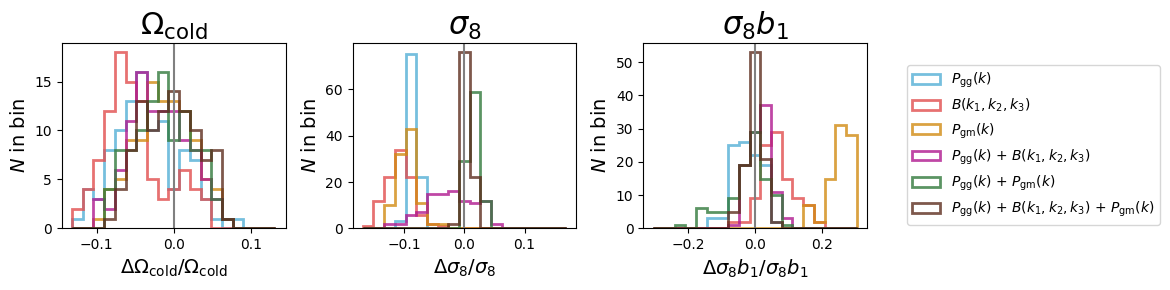

In [8]:
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        

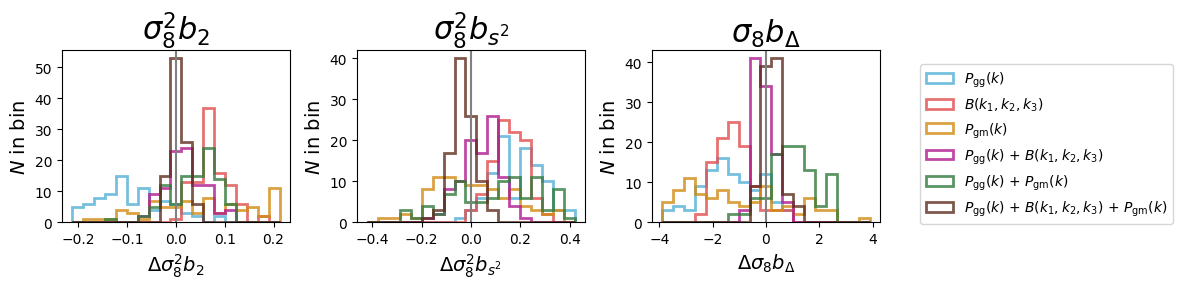

In [9]:
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_bias_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False, use_abs_diff=True)                        

# inference: noisy

In [33]:
# Inference setup - change these as needed
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'
tag_reparam = '_rp'
n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pgm'], ['pk', 'bispec'], ['pk', 'pgm'], ['pk', 'bispec', 'pgm']]
#statistics_arr = [['pk']]

tags_inf, labels, colors, tag_stats_arr = setup_inference_tags(
    data_mode, tag_params, tag_biasparams, statistics_arr, tag_noise, tag_Anoise, tag_reparam, n_train
)

In [34]:
# Load training set parameters
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary, param_names_vary = load_training_params(
    tag_params, tag_biasparams, tag_Anoise
)
print(f"Varying parameters: {param_names_vary}")

Varying parameters: ['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


### cosmic var

In [35]:
# Test set setup - change these as needed
tag_params_test = '_quijote_p0_n1000'
tags_biasparams_test = '_b1000_p0_n1'  # Can be str (repeated) or list
tag_noise = '_noise_unit_quijote_p0_n1000'
tag_Anoise = '_Anmult_p0_n1'
n_test_eval = 100

tags_data_test = setup_test_tags(data_mode, tag_params_test, tags_biasparams_test, tag_stats_arr, n_test_eval, 
                                 tag_noise_test=tag_noise, tag_Anoise_test=tag_Anoise)
for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100
_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100
_muchisimocks_pgm_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100
_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100
_muchisimocks_pk_pgm_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100
_muchisimocks_pk_bispec_pgm_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100


In [36]:
# Parameters to show in plots
param_names_show = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1', 
                   'sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']

# Convert tags_biasparams_test to list if it's a string
if isinstance(tags_biasparams_test, str):
    tags_biasparams_test_list = [tags_biasparams_test] * len(tags_inf)
else:
    tags_biasparams_test_list = tags_biasparams_test

# Load test predictions and true values
theta_true_arr, theta_pred_arr, vars_pred_arr, covs_pred_arr, param_names = load_test_predictions(
    tags_inf, tags_data_test, tag_params_test, tags_biasparams_test_list,
    cosmo_param_names_vary, bias_param_names_vary, param_names_vary,
    tag_reparam=tag_reparam, n_test_eval=n_test_eval, param_names_show=param_names_show,
    tags_Anoise_test=tag_Anoise, noise_param_names_vary=noise_param_names_vary
)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_pgm_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_bispec_

/dipc/kstoreyf/muchisimocks/scripts/plotter.py:184: RuntimeWarning: divide by zero encountered in divide
  diffs_arr = theta_pred_arr / theta_true_arr - 1


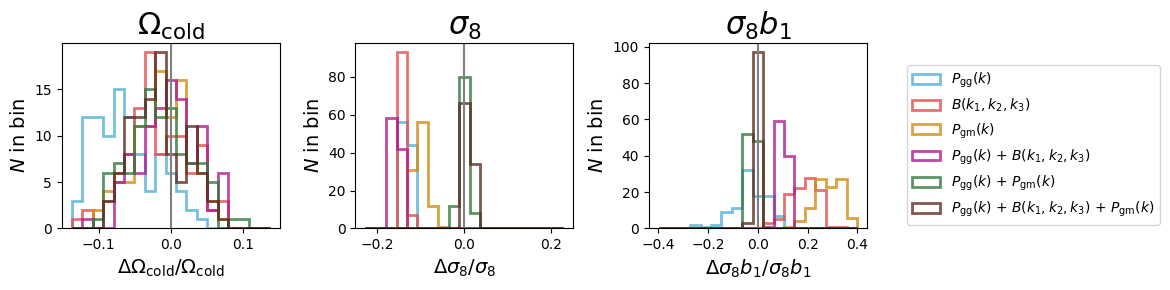

In [37]:
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        

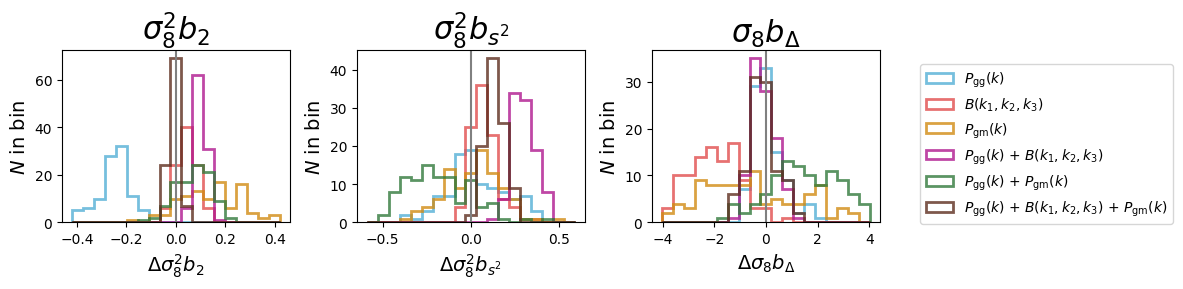

In [38]:
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_bias_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False, use_abs_diff=True)                        

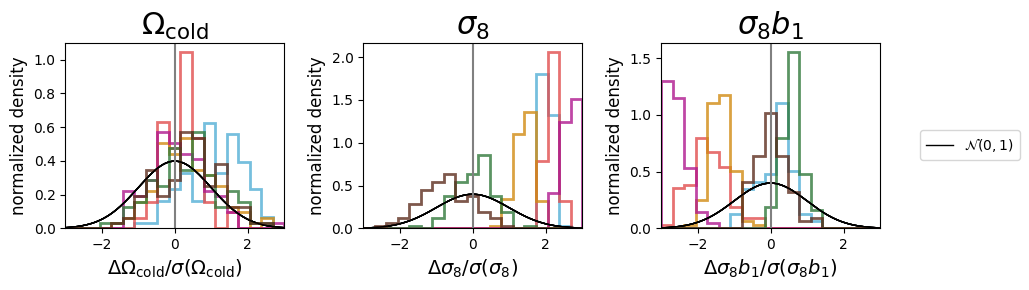

In [40]:
sigmas_from_truth_arr, chi2s_arr = plotter.plot_dists_cov_subplots(theta_pred_arr, theta_true_arr, covs_pred_arr, param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        

# inference: noisy (kmaxbispec=0.25)

In [7]:
# Inference setup - change these as needed
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'
tag_reparam = '_rp'
n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pgm'], ['pk', 'bispec'], ['pk', 'pgm'], ['pk', 'bispec', 'pgm']]
tags_mask = ['', '_kb0.25', '', '_kb0.25', '', '_kb0.25']

tags_inf, labels, colors, tag_stats_arr = setup_inference_tags(
    data_mode, tag_params, tag_biasparams, statistics_arr, tag_noise, tag_Anoise, tag_reparam, n_train,
    tags_mask=tags_mask
)

In [8]:
# Load training set parameters
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary, param_names_vary = load_training_params(
    tag_params, tag_biasparams, tag_Anoise
)
print(f"Varying parameters: {param_names_vary}")

Varying parameters: ['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


### cosmic var

In [9]:
# Test set setup - change these as needed
tag_params_test = '_quijote_p0_n1000'
tags_biasparams_test = '_b1000_p0_n1'  # Can be str (repeated) or list
tag_noise = '_noise_unit_quijote_p0_n1000'
tag_Anoise = '_Anmult_p0_n1'
n_test_eval = 100

tags_data_test = setup_test_tags(data_mode, tag_params_test, tags_biasparams_test, tag_stats_arr, n_test_eval, 
                                 tag_noise_test=tag_noise, tag_Anoise_test=tag_Anoise, tags_mask_test=tags_mask)
for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100
_muchisimocks_bispec_kb0.25_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100
_muchisimocks_pgm_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100
_muchisimocks_pk_bispec_kb0.25_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100
_muchisimocks_pk_pgm_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100
_muchisimocks_pk_bispec_pgm_kb0.25_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100


In [10]:
# Parameters to show in plots
param_names_show = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1', 
                   'sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']

# Convert tags_biasparams_test to list if it's a string
if isinstance(tags_biasparams_test, str):
    tags_biasparams_test_list = [tags_biasparams_test] * len(tags_inf)
else:
    tags_biasparams_test_list = tags_biasparams_test

# Load test predictions and true values
theta_true_arr, theta_pred_arr, vars_pred_arr, covs_pred_arr, param_names = load_test_predictions(
    tags_inf, tags_data_test, tag_params_test, tags_biasparams_test_list,
    cosmo_param_names_vary, bias_param_names_vary, param_names_vary,
    tag_reparam=tag_reparam, n_test_eval=n_test_eval, param_names_show=param_names_show,
    tags_Anoise_test=tag_Anoise, noise_param_names_vary=noise_param_names_vary
)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_bispec_kb0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_bispec_kb0.25_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pgm_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_pgm_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_neval100_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kb0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_mu

/dipc/kstoreyf/muchisimocks/scripts/plotter.py:184: RuntimeWarning: divide by zero encountered in divide
  diffs_arr = theta_pred_arr / theta_true_arr - 1


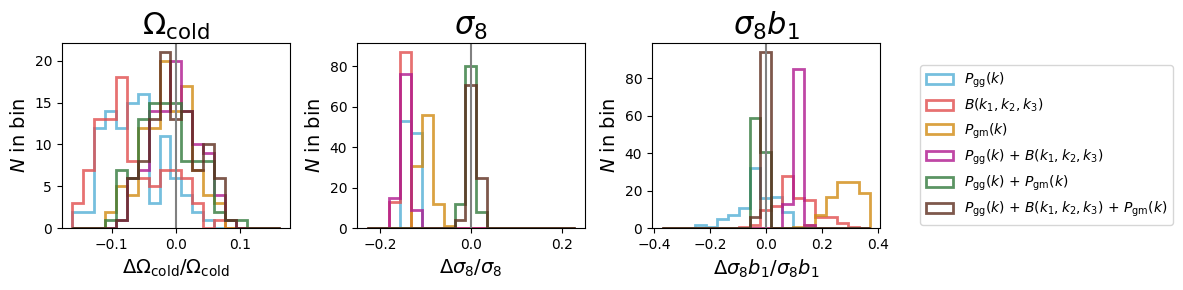

In [11]:
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        

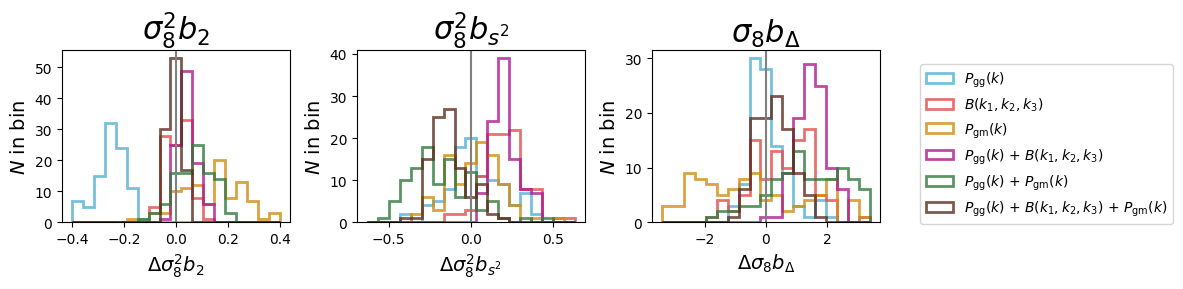

In [12]:
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_bias_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False, use_abs_diff=True)                        

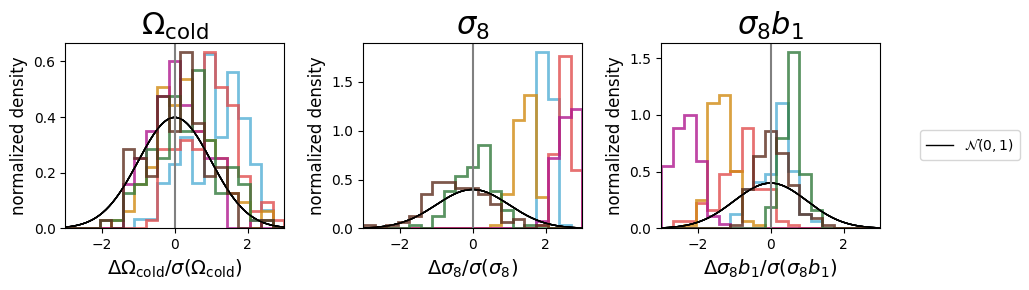

In [13]:
sigmas_from_truth_arr, chi2s_arr = plotter.plot_dists_cov_subplots(theta_pred_arr, theta_true_arr, covs_pred_arr, param_names_show, 
                        param_names_plot=param_names_key_rp, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        alpha=0.8, histtype='step',
                        xlim_auto=False, plot_cdf=False)                        